# Prony series identification for linear viscoelastic material models
Martin Springer | 2022 v0.1 

***


## Theory of linear viscoelasticity

Theory of linear [viscoelasticity](https://en.wikipedia.org/wiki/Viscoelasticity) is used to describe the mechanical response of polymer materials under small strain conditions. An extensive review can be found in [Brinson H. F., Brinson L. C,. Polymer Engineering Science and Viscoelasticity,
Springer, (2015)](https://link.springer.com/book/10.1007/978-1-4899-7485-3). A brief summary is provided below outlining the equations used in this notebook. The summary was extracted from [Springer, M., and Bosco N. Prog Photovolt 28.7 (2020): 659-681](https://onlinelibrary.wiley.com/doi/full/10.1002/pip.3257). <br/><br/>
   


  ### Mathematical description
  
  The rate-dependent material behavior can be described in either the time or frequency domain. In the time domain, the uniaxial, nonaging, isothermal stress-strain equation for a linear viscoelastic material can be represented by a Boltzmann superposition integral,
  
  \begin{equation}
  \sigma(t) = \int_0^t E(t-\tau) \frac{\mathrm{d \varepsilon(\tau)}}{\mathrm{d} \tau} \mathrm{d} \tau \quad ,
  \end{equation}
  
  where $\sigma(t)$ is the stress response over time, $t$; $E(t)$ is the relaxation modulus; $\varepsilon$ denotes the strain; and $\tau$ is the integration variable. The limiting moduli for the viscoelastic material are defined as the instantaneous modulus, $E(t=0) = E_0$, and the equilibrium modulus, i.e., $E(t) \rightarrow E_{\infty}$ for $t \rightarrow \infty$. 
  
  The [Generalized Maxwell Model](https://en.wikipedia.org/wiki/Generalized_Maxwell_model) is commonly used to represent the stress-strain response of polymers. The relaxation modulus derived from this model is given by,
  
  \begin{equation}
  E(t) = E_{\infty} + \sum\limits_{i=1}^{m} E_i \exp\left(-\frac{t}{\tau_i} \right) \quad ,
  \label{eq:RelProny}
  \end{equation}
  
  where $\tau_i$ (relaxation times),  $E_i = E_0 \alpha_i$ (relaxation moduli) are material properties, and $m$ is the number of terms in the series. The above equation is often referred to as Prony series, and the equilibrium modulus can be defined by the Prony series as,
  
  \begin{equation}
  	E_{\infty} = E_0 \left[1-\sum_{i=1}^N \alpha_i \right] \quad .
  \end{equation}
  
  The material properties can be directly obtained from relaxation or frequency-dependent test data. Material properties measured in the time domain can be converted into the frequency domain, and vice versa, by making use of a Fourier transformation,
  
  \begin{align}
  E'(\omega) &= E_{\infty} + \sum\limits_{i=1}^{m}\frac{\omega^2 \tau_i^2 E_i}{\omega^2 \tau_i^2 + 1} \quad ,
  \label{eq:PronyStor} \\
  E''(\omega) &= \sum\limits_{i=1}^{m} \frac{\omega \tau_i E_i}{\omega^2 \tau_i^2 +1} \quad .
  \label{eq:PronyLoss}
  \end{align}
  
  Herein, $E'(\omega)$ is the storage modulus, $E''(\omega)$ is the loss modulus, and $\omega = 2 \pi f$ is the angular frequency, where $f=1/t$ is the frequency in Hertz and $t$ is the time period in seconds, respectively. The complex modulus, $E^*(\omega)$, and the loss factor, $\tan(\delta)$, are given as,
  
  \begin{align}
  E^*(\omega) &= E'(\omega)  + i E''(\omega) \quad \text{and} \\
  \tan(\delta)  & =  \frac{E''(\omega)}{E'(\omega)} \quad ,
  \end{align}
  
  respectively.
  
  ### Experimental characterization
  
  An efficient way to determine the storage modulus, $E'(\omega)$, and the loss modulus, $E''(\omega)$, is by dynamic mechanical analysis (DMA) or dynamic mechanical thermal analysis (DMTA). The material under test is excited to mechanical steady-state oscillations, either load- or displacement-controlled, and the corresponding response is measured. Alternatively, relaxation experiments in the time domain can be conducted to determine the relaxation modulus, $E(t)$.
  
  Measurements at very low frequencies (long time periods) can be very time-consuming and might be unfeasible for practical applications. On the other side of the spectrum, measurements at very high frequencies can be limited by the instrumentation or unintended heating of the sample during cyclic deformation. To avoid such situations, the [time-temperature superposition principle (TTSP)](https://en.wikipedia.org/wiki/Time%E2%80%93temperature_superposition) is applied for thermo-rheologically simple materials. For such materials, the viscoelastic response at one temperature is related to the viscoelastic response at another temperature by changing the time scale (or frequency). This way, the time scale for the materials characterization can be extended by conducting the same frequency measurements at different temperatures. Afterward, a reference temperature is selected, and the isothermal measurements are shifted on a logarithmic time (or frequency) scale to form a so–called master curve.
  
  ![TTSP](figures/TTSP_small.png)
  
  Time-temperature shift factors, $a_{\mathrm{T}}(\theta)$, are defined as the horizontal shift that must be applied to individual measurements at a constant temperature, $\theta_i$, to form the master curve at the reference temperature, $\theta_{\mathrm{ref}}$.
  
  The determined shift factors, $a_{\mathrm{T}}$, are used to define a shift function that describes the temperature dependence of the viscoelastic material. Different shift functions for various materials are available in the literature. A commonly used shift function is the the [Williams-Landel-Ferry (WLF)](https://en.wikipedia.org/wiki/Williams%E2%80%93Landel%E2%80%93Ferry_equation),
  
  \begin{equation}
  \log(a_{\mathrm{T}}) = -\frac{C_1\left(\theta-\theta_{\mathrm{ref}}\right)}{C_2 + \left(\theta-\theta_{\mathrm{ref}}\right)}
  \label{eq:WLF_shift}
  \end{equation}
  
  where $\theta_{\mathrm{ref}}$ is the reference temperature of the master curve. $\theta$ is the temperature of interest, and $C_1$ and $C_2$ are calibration constants.  The TTSP is based on the kinetic theory of polymers, which is strictly speaking only valid above the glass transition temperature, $\theta_g$. Although the TTSP is thought to be valid also for temperatures below $\theta_g$, the exact lower limit is not well defined, and the principle is commonly applied to temperatures below $\theta_g$ as long as the measurement data are shiftable to form a smooth master curve. Alternatively, different shift functions can be fitted. Below we provide a routine to fit polynomial shift function up to degree four.

In [1]:
%matplotlib widget

import LinViscoFit as visco
#import ipywidgets as widgets

#import pandas as pd
#import io
#import os

#from IPython.display import display, clear_output, HTML
#from base64 import b64encode
#import matplotlib.pyplot as plt
#pd.set_option('display.float_format', '{:.5e}'.format)

visco.format_fig()
GUI = visco.GUIControl()

***
## Parameter identification

The linear viscoelastic curve fitting routine in this notebook allows for experimental data in both the time and frequency domains. The following conventions are used within this notebook:

| Physical quantity      | Symbol          | Variable   | Unit   |
| :--------------------- | :-------------: | :--------- | :----: |
| Relaxation modulus:    | $E(t)$          | `E_relax`  | MPa    |
| Storage modulus:       | $E'(\omega)$    | `E_stor`   | MPa    |
| Loss modulus:          | $E''(\omega)$   | `E_loss`   | MPa    |
| Complex modulus:       | $|E^{\ast}|$    | `E_comp`   | MPa    |
| Loss modulus:          | $\tan(\delta)$  | `tan_del`  | -      |
| Instantaneous modulus: | $E_0$           | `E_0`      | MPa    |
| Equilibrium modulus:   | $E_{inf}$       | `E_inf`    | MPa    |
| Angular frequency:     | $\omega$        | `omega`    | rad/s  |
| Frequency:             | $f$             | `f`        | 1/s    |
| Time:                  | $t$             | `t`        | s      |
| Temperature:           | $\theta$        | `T`        | °C     |


### Specify and upload input data

#### Domain
This notebook allows for the estimation of Prony series parameters used in a Generalized Maxwell model to describe the linear viscoelastic behavior of polymer materials. The parameters can be either fitted from measurement data of Dynamic mechanical thermal analysis (DMTA) in the frequency domain (freq) or from relaxation experiments in the time domain (time). 

#### Instrument
DMTA measurements conducted with a Netzsch Gabo DMA EPLEXOR (Eplexor) can be directly uploaded in this notebook as Excel files. Use the `Excel Export!` feature of the Eplexor software with the default template to create the input files. For measurements conducted with other instruments choose the user option (user) and preprocess the input files to be provided in comma-separated values (csv) format with the following columns header:
* **Frequency domain:** header = `f, E_stor, E_loss`, where `f` is the frequency in Hertz (Hz), and ```E_stor``` and `E_loss` are the storage and loss modulus in Megapascal (MPa), respectively.
* **Time domain:** header = `t, E_relax`, where `t` is the time in seconds (s), and `E_relax` is the relaxation modulus in MPa.

#### Type
The data can be provided as measurement sets at different temperatures (raw) or as master curve obtained from time-temperature superposition (master). If measurements at different temperatures are provided (raw) the individual temperature sets need to be identified. 
* **Eplexor** The notebook identifies the corresponding temperature sets automatically (only available in the frequency domain).
* **user** Two additional columns are necessary in the input file. One column indicating the temperature `T` of the measurement sets and one column with the header `Set` to identify the measurement sets. All measurements at the same temperature set are marked with the same number, e.g. 0 for all measurements in the the first temperature set. The first tempeature set (0) represents the coldest temperature followed by the second set (1) at the next higher temperature level and so forth (see the provided example input files for further details).

#### Example input files
A set of example input files is provided in a GitHub repository.
[Link to example input files](https://github.com/martin-springer/LinViscoFit/tree/main/examples)

In [2]:
display(GUI.w_inp_gen)

#### Reference temperature 

Reference temperature refers to the temperature for which the master curve has been created through time-temperature superpostion. 

If a master curve from the Eplexor software is provided the reference temperature will be automatically extracted. 

For all other options please provide either the reference temperature of the user-specified master curve or the desired reference temperature for the time-temperature superposition of the raw data (for raw data the desired reference temperature will be automatically adjusted to align with the closest provided temperature set of the measurement input file).

#### Optional shift factor upload
If master curves are provided, the shift factor upload is optional and allows for the calculation of polynomial (D1 to D4) shift functions and the Williams–Landel–Ferry (WLF) shift function, but is not required for the Prony series estimation. 

If a master curve from created by the Eplexor software is provided, the default behavior of the notebook is to use the WLF shift function from the Eplexor software. However, in the time-temperature superpostion section, a checkbox is provided to overwrite the WLF fit of the Eplexor software and conduct another WLF fit with the algorithm in this notebook, which is then used to estimate the Prony series parameters.

If raw measurement data are provided (for both Eplexor or user), the shift factors can be either determined for the desired reference temperature in the time-temperature superposition section or user-specified shift factors can be uploaded to be used to create the master curve. 

In [3]:
display(GUI.w_inp_shift)

#### Load and check the provided input files

Once all the input parameter are specified and the necessary files are uploaded click the *Load data* button below. If the input files could be loaded successfully, the widgets will indicate the state of the uploaded data.

In [4]:
display(GUI.w_inp_load)
#display(GUI.w_inp_check)

***
### Time-temperature superposition (shift functions)

This section allows to calulate shift factors from raw input data and fit shift functions.

#### Shift factors $\log(a_{T})$ - Create master curve from raw input

This subsection only applies if raw input data have been provided. If master curves have been uploaded, please procede to the next step. 

Here, the time-temperature superposition principle is applied to create a master curve from the individual temperature measurement sets provided in the raw input data file. If user shift factors, $\log(a_{T})$, are uploaded, the provided shift factors will be used to create the master curve from the raw measurement sets at different temperatures (the checkbox allows you to overwrite the provided shift factors). If no shift factors are provided, the measurement sets from the raw input file are used to estimate the shift factors and create a master curve. Measurement sets below the desired reference temperatures are shifted to lower frequencies (longer time periods), whereas measurement sets at temperatures higher than the reference temperature are shifted to higher frequencies (shorter time periods). For the frequency domain, only the storage modulus input data are considered to create the master curve from the raw input data. The shift factors obtained from creating the storage modulus master curve are then used to create the loss modulus master curve.

In [5]:
display(GUI.w_aT)

#### Shift functions (WLF & Polynomial degree 1 to 4)

If shift factors are available, the WLF shift function and polynomial functions of degree 1 to 4 can be fitted and plotted below. If the WLF shift functions was already provided by the Eplexor software, the checkbox below let's you overwrite the WLF fit of the Eplexor software with a WLF fit of this notebook. Either way, both solutions should be very similar. 

In [6]:
display(GUI.w_shift)

***
### Estimate Prony series parameters

#### Pre-process (smooth) master curve

A moving median filter to remove outliers in the measurement data can be applied before the Prony series parameters are identified. The window size (win) can be adjusted through the slider above the figure. A window size of 1 means that no filtering procedure is performed and the raw data are fitted.

In [7]:
display(GUI.b_smooth)
display(GUI.out_smooth)

Button(button_style='info', description='smooth master curve', layout=Layout(height='auto', width='200px'), st…

Output()

#### Define the number and discretization of the Prony series

The number of Prony terms, $N$, needs to be defined before the parameter $\tau_i$ and $\alpha_i$ can be identified. The default behavior is to equally space one Prony term per decade along the logarithmic time axis, $\tau_i$ = [1E-1, 1E0, 1E1,...] (s), within the experimental window. This discretization typically delivers accurate results for engineering applications. However, the fine discretization can be computationally heavy for usage in Finite Element simulations. Hence, we allow the user to modify this default discretization by either using the optimization routine provided below or by manually defining the number of Prony terms $N$ for the discretization. Additionally, the user can decide wether to round the lowest and highest relaxation times, $\tau_i$, to the nearest base 10 number within the measurement window (round) or to use the exact minimum and maximum values of the experimental window for the relaxation times (exact). 

In [8]:
display(GUI.w_dis)

#### Curve fitting

Two different curve fitting routines for the Prony series parameters are employed and are dependent on the domain of the input data:

* **Frequency domain**: A generalized collocation method using stiffness matrices is used as described in [Kraus, M. A., and M. Niederwald. Eur J Eng Mech 37.1 (2017): 82-106](https://journals.ub.ovgu.de/index.php/techmech/article/view/600). This methods utilizes both the storage and loss modulus master curves to estimate the Prony series parameters.
   
   
* **Time domain**: A nonlinear least-squares optimization is performed with the L-BFGS-B algorithm of the scipy package. The implementation is similar to the optimization problem described by [Barrientos, E., Pelayo, F., Noriega, Á. et al. Mech Time-Depend Mater 23, 193–206 (2019)](https://doi.org/10.1007/s11043-018-9394-z) for a homogenous distribution of discrete times. 

In [9]:
display(GUI.b_fit)
display(GUI.out_fit)

Button(button_style='danger', description='fit Prony series', layout=Layout(height='auto', width='200px'), sty…

Output()

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [26]:
def E_relax(time, alpha_i, tau_i, E_0):
    #return E_0 * (1-np.dot(alpha_i, 1-np.exp(-time/tau_i[:,None])))
    return 1-np.dot(alpha_i, 1-np.exp(-time/tau_i[:,None]))
    
    #y = np.zeros(time.shape[0])
    #for i, t in enumerate(time):
    #    y[i] = E_0 * (1 - np.sum(alpha_i*(1-np.exp(-t/tau_i))))
    #return y


def residual(alpha_i, tau_i, E_0, E_relax_meas, time_meas):
    #return np.sum((1 - E_relax(time_meas, alpha_i, tau_i, E_0)/E_relax_meas)**2)
    return np.sum((E_relax_meas - E_relax(time_meas, alpha_i, tau_i, E_0))**2)

def residual_tau(tau_i, alpha_i, E_0, E_relax_meas, time_meas):
    #return np.sum((1 - E_relax(time_meas, alpha_i, tau_i, E_0)/E_relax_meas)**2)
    return np.sum((E_relax_meas - E_relax(time_meas, alpha_i, tau_i, E_0))**2)

def fit_prony_time_alpha(df_dis, df_master, alpha_i, tau_i):

    #alpha_i = np.ones(df_dis['tau'].values.shape) #start all a_i = 1
    #tau_i = df_dis['tau'].values
    E_0 = df_dis.E_0
    E_relax_meas = df_master['E_relax_filt'].values / E_0
    time_meas = df_master['t'].values
    N = df_dis.nprony
    bnd = ((0,1),)*alpha_i.shape[0]

    res = minimize(residual, alpha_i, args=(tau_i, E_0, E_relax_meas, time_meas), method='L-BFGS-B', bounds=bnd)
    
    #print(res)
    
    alpha = res.x

    df = pd.DataFrame()
    
    #Ensure that Sum(alpha_i) < 1 (otherwise can lead to numerical difficulties in FEM)
    if alpha.sum() >= 1:
        df['alpha'] = 0.99/alpha.sum()*alpha #Normalize alpha values to 0.99
    else:
        df['alpha'] = alpha
        
    df['tau'] = tau_i

    df_prony = df[['tau', 'alpha']].copy()
    df_prony = df_prony.iloc[::-1].reset_index(drop=True)
    df_prony.index += 1 
    df_prony.RefT = df_dis.RefT

    #Prepare input arguments for generalized Maxwell model
    f_min = df_dis['f'].iloc[0]
    f_max = df_dis['f'].iloc[-1]

    prony = {'E_0':E_0, 'df_terms':df_prony, 'f_min':f_min, 'f_max':f_max, 'label':'equi.'}
    
    return prony

def fit_prony_time_tau(df_dis, df_master, tau_i, alpha_i):

    #print(tau_i)
    E_0 = df_dis.E_0
    E_relax_meas = df_master['E_relax_filt'].values / E_0
    time_meas = df_master['t'].values
    N = df_dis.nprony
    #bnd = ((0,1),)*alpha_i.shape[0]
    
    f_min = GUI.df_dis['f'].iloc[0]
    f_max = GUI.df_dis['f'].iloc[-1]

    tau_max = 1/(2*np.pi*f_min)
    tau_min = 1/(2*np.pi*f_max)

    bnd_min = 10**(np.log10(tau_i)-1)
    bnd_min[0] = tau_min
    bnd_max = 10**(np.log10(tau_i)+1)
    bnd_max[-1] = tau_max
    bnd = tuple(zip(bnd_min, bnd_max))

    res = minimize(residual_tau, tau_i, args=(alpha_i, E_0, E_relax_meas, time_meas), method='L-BFGS-B' , bounds=bnd) #
    
    #print(res)
    
    tau = res.x
    
    df = pd.DataFrame()
    df['tau'] = tau
    df['alpha'] = alpha_i

    #Ensure that Sum(alpha_i) < 1 (otherwise can lead to numerical difficulties in FEM)
    #if alpha.sum() >= 1:
    #    df_dis['alpha'] = 0.99/alpha.sum()*alpha #Normalize alpha values to 0.99
    #else:
    #    df_dis['alpha'] = alpha

    df_prony = df[['tau', 'alpha']].copy()
    df_prony = df_prony.iloc[::-1].reset_index(drop=True)
    df_prony.index += 1 
    df_prony.RefT = df_dis.RefT

    #Prepare input arguments for generalized Maxwell model
    f_min = df_dis['f'].iloc[0]
    f_max = df_dis['f'].iloc[-1]

    prony = {'E_0':E_0, 'df_terms':df_prony, 'f_min':f_min, 'f_max':f_max, 'label':'equi.'}
    
    return prony

In [15]:
prony = GUI.prony
tau_i = prony['df_terms']['tau'].values
alpha_i = prony['df_terms']['alpha'].values

In [24]:
f_min = GUI.df_dis['f'].iloc[0]
f_max = GUI.df_dis['f'].iloc[-1]

tau_max = 1/(2*np.pi*f_min)
tau_min = 1/(2*np.pi*f_max)

bnd_min = 10**(np.log10(tau_i)-1)
bnd_min[0] = tau_min
bnd_max = 10**(np.log10(tau_i)+1)
bnd_max[-1] = tau_max
bnd = tuple(zip(bnd_min, bnd_max))

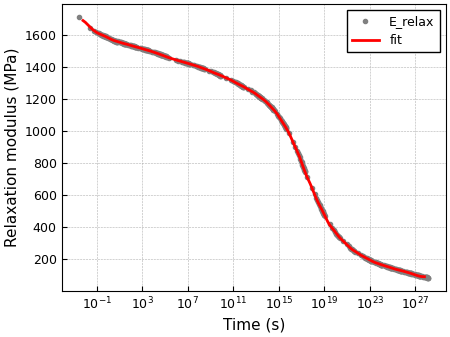

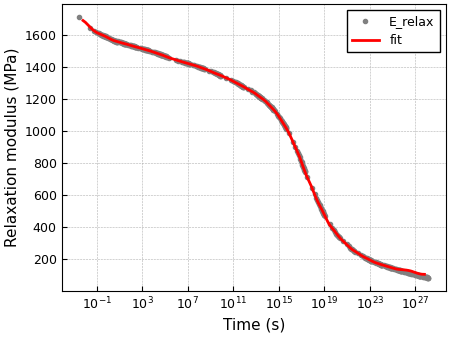

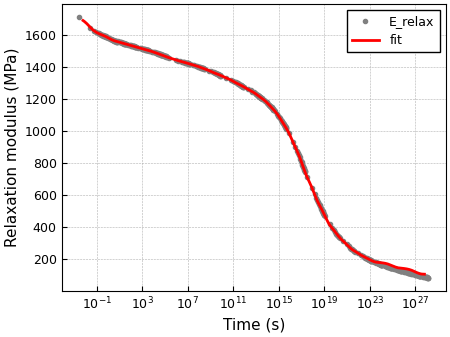

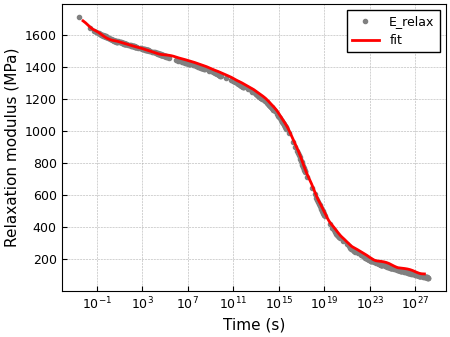

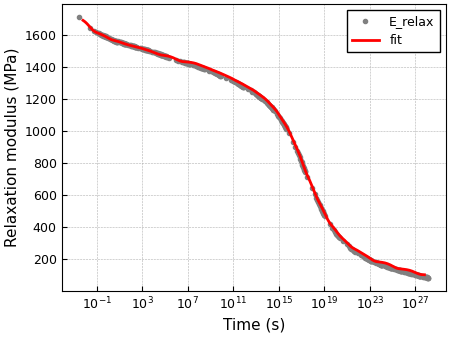

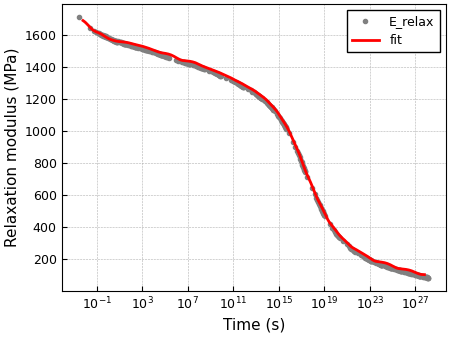

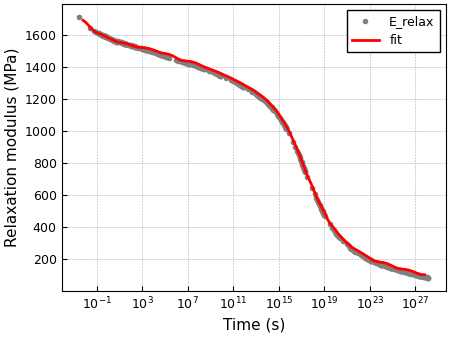

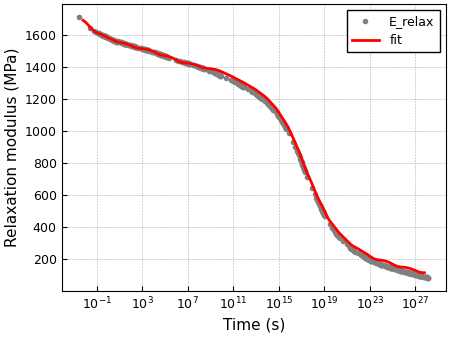

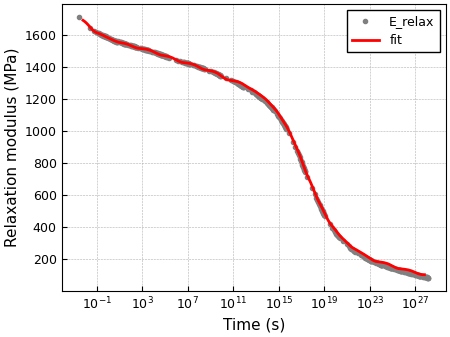

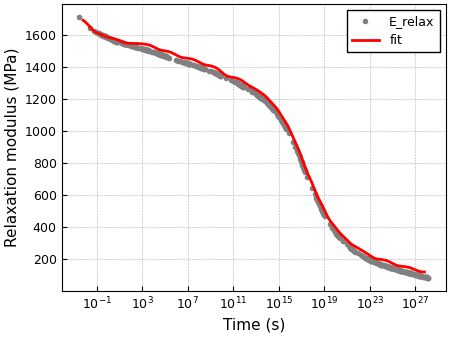

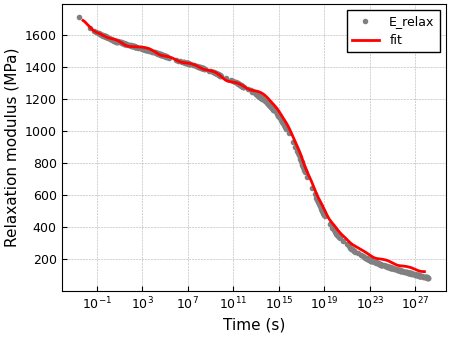

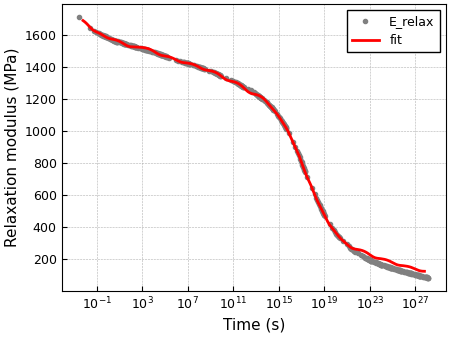

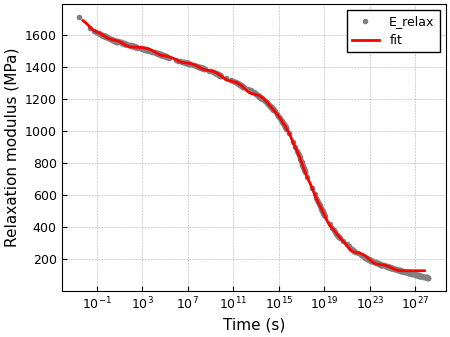

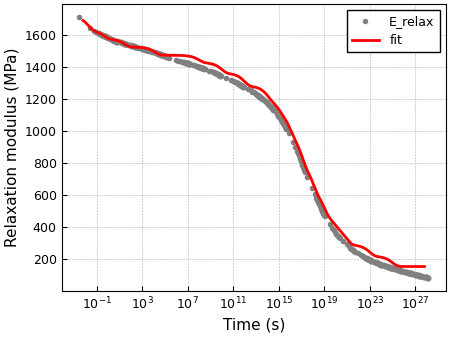

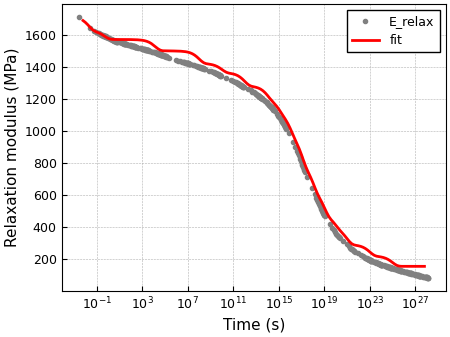

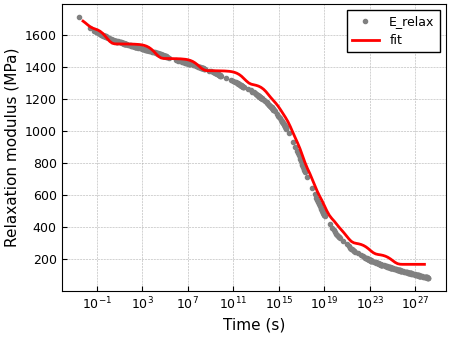

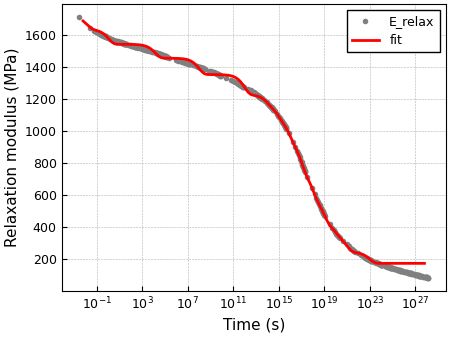

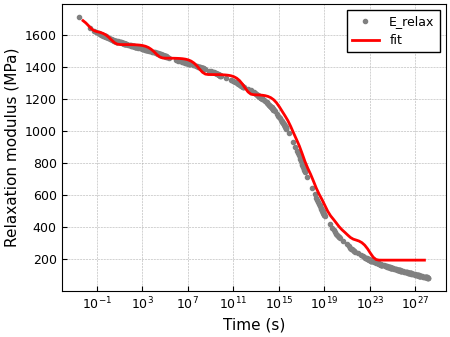

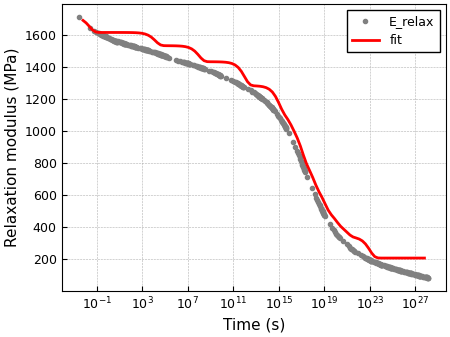

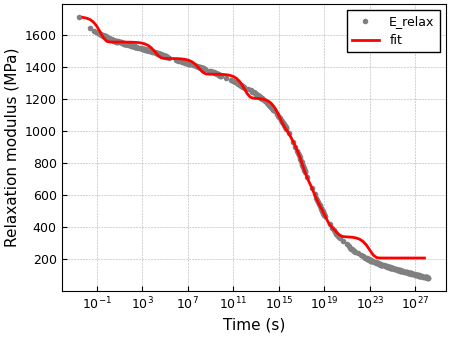

In [31]:
prony = GUI.prony

for i in range(20):

    tau_i = prony['df_terms']['tau'].values
    alpha_i = prony['df_terms']['alpha'].values
    prony = fit_prony_time_alpha(GUI.df_dis, GUI.df_master, alpha_i, tau_i)
    
    prony['df_terms'] = prony['df_terms'].drop(prony['df_terms']['alpha'].idxmin()) #.iloc[1:-1]
    
    tau_i = prony['df_terms']['tau'].values
    alpha_i = prony['df_terms']['alpha'].values
    prony = fit_prony_time_tau(GUI.df_dis, GUI.df_master, tau_i, alpha_i)
    
    df_GMaxw = visco.calc_GenMaxw(**prony)
    visco.plot_fit(GUI.df_master, df_GMaxw);

In [32]:
prony

{'E_0': 1714.266,
 'df_terms':              tau     alpha
 1   2.198709e-01  0.092279
 2   1.445259e+04  0.059657
 3   9.999755e+07  0.057093
 4   1.000000e+12  0.087248
 5   1.000000e+15  0.088947
 6   1.000000e+16  0.056539
 7   1.000000e+17  0.121820
 8   1.000000e+18  0.093791
 9   1.000000e+19  0.090649
 10  1.000000e+20  0.052422
 11  1.000000e+23  0.077689,
 'f_min': 1.5915494309189536e-28,
 'f_max': 159.15494309189535,
 'label': 'equi.'}

### Optimization

***
### Generalized Maxwell model

In [ ]:
display(GUI.b_GMaxw)
display(GUI.out_GMaxw)


***
### Download results and figures

In [ ]:
display(GUI.db_zip)

In [ ]:
#old
display(GUI.db_prony)

***
### Start over

In [ ]:
display(GUI.b_reload)
display(GUI.out_html)

***
## Verification - Compare with Ansys